# Met Office Aircraft Data Exploration

![JCEEI logo](../jceei_logo.png)

______________________________________________________________________

In this notebook, aircraft data is taken from the [CEDA](https://www.ceda.ac.uk) data archive programmatically. The sources of this data are: the [FAAM](https://www.faam.ac.uk) repository and the repository of the [Meteorological Research Flight (MRF) facility](https://catalogue.ceda.ac.uk/uuid/605b99a139b1162de6a1096a11b0a8b4#:~:text=The%20Met.%20Research%20Flight%20%28MRF%29%20was%20a%20Met,to%202001%20and%20flew%20over%201800%20research%20sorties.). MRF data is held in the [Nasa Ames](https://espo.nasa.gov/content/Ames_Format_Overview) format, and the chosen FAAM data that is downloaded will be [netCDF](https://en.wikipedia.org/wiki/NetCDF). The data is explored by the means of some basic visualizations using tools [Xarray](https://xarray.dev), [Matplotlib](https://matplotlib.org/), [Pandas](https://pandas.pydata.org)

### Prerequisites

The most important prerequisite to this tutorial is to generate a certificate from the CEDA website and shell script using your CEDA account. CEDA provides a [guide](https://help.ceda.ac.uk/article/4442-ceda-opendap-scripted-interactions) for certificate generation, the file-path for the generated certificate must be set in the environment variable below.

## Contents

- netCDF
  - Scrape CEDA
    - download the links
  - Explore the downloaded data
- Nasa Ames
  - Download as before
  - Explore
-
-

## How To Generate a certificate on CEDA and link to environment variable

- Step 1: Create an Account on CEDA
- Step 2: Clone the CEDA certificate generation repository to your local machine (in an appropriate location) e.g. 
```bash
cd ~; 
git clone https://github.com/cedadev/online_ca_client; 
```
- Step 3: Navigate to the certificate generation script in the cloned repository e.g.
```bash
cd online_ca_client/contrail/security/onlineca/client/sh/
```
- Step 4: Generate the trustroots dependency required for certificate generation
```bash
./onlineca-get-trustroots-wget.sh -U https://slcs.ceda.ac.uk/onlineca/trustroots/ -c ~/trustroots -b
```
- Step 5: Generate a security certificate (replacing \<ceda username\> with your ceda username). The terminal will then prompt for a password after the command is run
```bash
./onlineca-get-cert-wget.sh -U  https://slcs.ceda.ac.uk/onlineca/certificate/ -c ~/trustroots -l <ceda username> -o creds.pem
```
- Step 6: Find the creds.pem file and link the path of the file to the notebook by pasting the path into the environment (.env) file e.g. in .env: 

```
CEDA_CERTIFICATE_DIRECTORY=/example_directory/home/online_ca_client/contrail/security/onlineca/client/sh/creds.pem
----> 
CEDA_CERTIFICATE_DIRECTORY=~/online_ca_client/contrail/security/onlineca/client/sh/creds.pem
```

In [1]:
import glob
import os
import sys

import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import xarray as xr
from bs4 import BeautifulSoup

# clear cell outputs when private information is displayed
from IPython.display import clear_output

HIDE_SECRET_OUTPUT = True

In [2]:
# notebook settings
env_file_path = ".env"

For this notebook, a .env file is defined in order to abstract away keys personal to the user. The .env file is kept in the same directory as this notebook. Here is an example of what the .env file looks like:

```
ATMOSPHERIC_CLIENT_ID=xxxxxxxxxxxxxxxxxxxxxx
ATMOSPHERIC_CLIENT_SECRET=xxxxxxxxxxxxxxxxxxxxxx
SOME_OTHER_ENV_VAR=2gt2t1t2t7224pZ/*321
```

As shown, the format for each variable is ENV_VAR_NAME=ENV_SECRET with no spaces between the '=' and the definitions, or at the beginning of a line. A newline is required between each environment variable.
<br>Due to how the file is read without a the common tool `dotenv`, the .env file expects no comments, nor an in-file informational header. The names of each variable should be obvious.
<br>
<br>A __template file for .env__ is given in the repository called `.env_template`. after filling in the template with the users own information, either rename the file itself, or the path to the file in the setting variable above (env_file_path)

In [3]:
# read environment file
env_vars = {}

with open(env_file_path) as f:
    for line in f:
        key, value = line.strip().split("=", 1)
        env_vars[key] = value

print(env_vars)
if HIDE_SECRET_OUTPUT:
    clear_output()

In [4]:
# load environment variables
CERT_SECRET = env_vars["CEDA_CERTIFICATE_DIRECTORY"]

### Scraping a CEDA repository

Scraping is the process of extracting data from websites, this is typically done in an automatic way with a "web crawler". Below a web crawler for a specified repository is defined.

The key tools to perform this crawl are: a [Recursive](https://en.wikipedia.org/wiki/Recursion_%28computer_science%29) implementation of [Depth-First-Search](https://en.wikipedia.org/wiki/Depth-first_search), html parser [Beautiful Soup](https://beautiful-soup-4.readthedocs.io/en/latest/), permission to search the repository (using the CEDA generated certificate), and some knowledge about the setup of the repository.

The result of this web crawl will be the links for all of the 1hz netCDF files in the FAAM data repository. the FAAM data repository has many different file extensions for the data: \[.zip, .txt, .html, .pdf, .kml, .ict, .dat, .xls, .ps, .na, and .nc\] . There also exist categories of data sorted into directories, e.g. directories with 'raw' in the name have not gone through any processing, so are ignored as this data is likely to be hard to handle. All forms of undesired data are ignored in the crawl, going down directories and pulling only the files specifically named after the 1hz data format. The 1hz data format is arguably the easiest data to handle.

In [5]:
cert_dir = CERT_SECRET  # certificate file location generated by https://help.ceda.ac.uk/article/4442-ceda-opendap-scripted-interactions
visited_urls = set()  # global sets to allow access in functions during recursion
download_links = set()
start_data_dir = (
    "./data/aircraft_data/netcdf_example"  # root directory for downloaded content
)


def crawl_directory(url, start_data_dir):
    if url in visited_urls:
        return

    visited_urls.add(url)

    response = requests.get(url, cert=(cert_dir))

    soup = BeautifulSoup(
        response.content, "html.parser"
    )  # parse the content, returns soup object

    if soup is None:  # if nothing is found in the htmlparse, end
        return

    #     os.makedirs(os.path.dirname(start_data_dir), exist_ok=True) # CREATE A NEW DIRECTORY/subdirectory in the download folder FOR EACH DIRECTORY ONLINE

    #     with open(os.path.join(start_data_dir, 'page.html'), "w", errors='ignore') as f:   # WRITE THE CONTENTS OF THE DIRECTORY IN THE DIRECTORY WITH A PAGE.HTML FILE FOR NAVIGATION
    #         f.write(str(soup))                                                             # (does not work without previous os.makdirs in most cases)

    for link in soup.find_all("a"):  # hrefs exist in anchor elements
        if link.has_attr("href"):
            href = link["href"]  # only explore links
        else:
            continue

        if href == "../":  # don't go up in directories
            continue
        elif href.endswith("/"):  # if the link is a further directory
            if (
                "non" in href
                or href == "core_processed_standard/"
                or href == "core_processed_cloud_physics/"
                or "temp" in href
                or "raw" in href
                or "video" in href
            ):  # ignore known undesirable directories in our specific use-case
                continue
            if (
                len(href) == 5
            ):  # print hrefs that are years just for easy progress tracking
                print("Looking in year:", href)
                if (
                    href == "2004/" or href == "2005/" or href == "2006/"
                ):  # doesn't contain any desired files
                    continue
            # look in the directory
            crawl_directory(os.path.join(url, href), os.path.join(start_data_dir, href))
        elif href.endswith("1hz.nc"):  # save diserable files

            # don't download if there is a more recent version
            all_links = soup.find_all("a")
            all_hrefs = list([link["href"] for link in all_links])
            all_1hz = [
                desired_nc_file
                for desired_nc_file in all_hrefs
                if "1hz.nc" in desired_nc_file
            ]
            # add all the 1hz files in this directory to the visited urls section (duplicates current href, but doesn't cause issue)
            for nc_1hz in all_1hz:
                visited_urls.add(os.path.join(url, nc_1hz))
            # add only the most recent revision to links that are kept
            all_1hz = sorted(all_1hz)
            most_recent_1hz = all_1hz[-1]
            download_links.add(
                os.path.join(url, most_recent_1hz)
            )  # if chosen to mirror the directory setup as is online, good idea to just download the file instead of save download link


file_start_url = "https://dap.ceda.ac.uk/badc/faam/data"
print("starting crawl")
crawl_directory(file_start_url, start_data_dir)
print("crawl end")
# convert 1hz.nc set to sorted list (sorts by year, then alphabetically on ?flightcode?)
download_links = sorted(
    list(download_links), reverse=True
)  # reverse to make recent data appear first in the list

# print(download_links)
print(len(download_links), "files found.")

starting crawl
Looking in year: 2004/
Looking in year: 2005/
Looking in year: 2006/
Looking in year: 2007/
Looking in year: 2008/
Looking in year: 2009/
Looking in year: 2010/
Looking in year: 2011/
Looking in year: 2012/
Looking in year: 2013/
Looking in year: 2014/
Looking in year: 2015/
Looking in year: 2016/
Looking in year: 2017/
Looking in year: 2018/
Looking in year: 2019/
Looking in year: 2020/
Looking in year: 2021/
Looking in year: 2022/
crawl end
1024 files found.


Now all of the links in the repository have been found, lets display the first and last entries of the data

In [6]:
print(download_links[:1])  # ':' not necessary when showing only 1 list item
print(download_links[-1:])

['https://dap.ceda.ac.uk/badc/faam/data/2022/c315-aug-08/core_processed/core_faam_20220808_v005_r0_c315_1hz.nc']
['https://dap.ceda.ac.uk/badc/faam/data/2007/b285-apr-19/core_processed/core_faam_20070419_v001_r0_b285_1hz.nc']


With the links found, download a portion of them for exploration:

In [7]:
# create directory to store data
save_dir = start_data_dir + "/"
os.makedirs(os.path.dirname(save_dir), exist_ok=True)
progress_check_number = (
    25  # if breaking on initial downloads, will download this many files
)

In [8]:
progress_counter = 0
BREAK_ON_INITIAL_DOWNLOADS = True  # Don't download a tonne of data, might destroy directory space, choose better disk otherwise
for hzfile in download_links:
    if progress_counter % progress_check_number == 0:
        print("Downloaded number of files:", progress_counter)
        if BREAK_ON_INITIAL_DOWNLOADS:
            if progress_counter > 0:
                break
    nc_file_name = hzfile.split("/")[-1]
    save_hzfile_path = f"{save_dir}{nc_file_name}"
    if not os.path.exists(
        save_hzfile_path
    ):  # don't download files if already exist on disk
        response = requests.get(hzfile, cert=(CERT_SECRET))
        response_content = response.content
        if response.status_code != 200:
            print(response_content)
            print(
                "\n!!!Exception, likely the certificate is not valid! response above!!!\n"
            )
            raise Exception()
        with open(save_hzfile_path, "wb") as f:
            f.write(response_content)
    progress_counter += 1

Downloaded number of files: 0
Downloaded number of files: 25


In [9]:
# take the most recent file
all_saved_files_pattern = save_dir + "*"
saved_files_most_recent_first = sorted(glob.glob(all_saved_files_pattern), reverse=True)
most_recent_file = saved_files_most_recent_first[8]

Below the file is opened with Xarray, the IPython print of the Xarray dataset should be interactive e.g. the values of a coordinate could be expanded to see the data, or attributes tab expanded to show the file metadata which is saved as an attribute. 

In [10]:
# Open the file
ds = xr.open_dataset(most_recent_file)
ds

<xarray.Dataset>
Dimensions:              (Time: 23969)
Coordinates:
  * Time                 (Time) datetime64[ns] 2022-07-30T13:24:31 ... 2022-0...
    LAT_GIN              (Time) float32 ...
    LON_GIN              (Time) float32 ...
Data variables: (12/178)
    P10_STAT             (Time) float32 ...
    P10_STAT_FLAG        (Time) float32 ...
    EXX_JCI              (Time) float32 ...
    EXX_JCI_FLAG         (Time) float32 ...
    LAT_GIN_FLAG         (Time) float32 ...
    LON_GIN_FLAG         (Time) float32 ...
    ...                   ...
    SEA_TWC_083          (Time) float32 ...
    SEA_TWC_083_FLAG     (Time) float32 ...
    SEA_LWC_021          (Time) float32 ...
    SEA_LWC_021_FLAG     (Time) float32 ...
    SEA_LWC_083          (Time) float32 ...
    SEA_LWC_083_FLAG     (Time) float32 ...
Attributes: (12/60)
    Conventions:                           CF-1.9 ACDD-1.3
    acknowledgement:                       Airborne data was obtained using t...
    comment:                               DCMEX science flight around Langmu...
    constants_file:                        flight-cst_faam_20220730_r0_c307.yaml
    creator_address:                       Building 146, Cranfield University...
    creator_email:                         info@faam.ac.uk
    ...                                    ...
    summary:                               Data gathered during flight c307 o...
    time_coverage_duration:                PT6H39M28S
    time_coverage_end:                     2022-07-30T20:03:59Z
    time_coverage_start:                   2022-07-30T13:24:31Z
    title:                                 FAAM core data from c307
    uuid:                                  acc0f0d5-6c96-3209-88fe-8b5501d9c1af

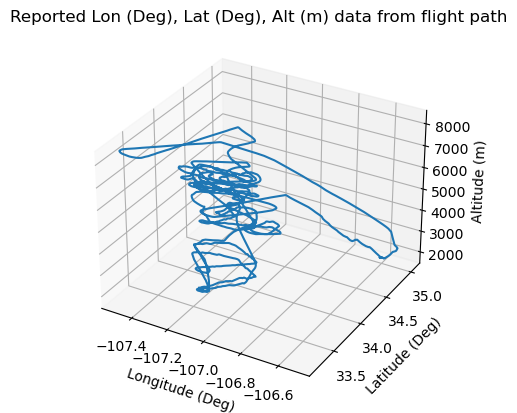

In [11]:
alt_vals = ds["ALT_GIN"]
lat_vals = ds["LAT_GIN"]
lon_vals = ds["LON_GIN"]
fig = plt.figure()
ax = fig.add_subplot(projection="3d")
ax.plot(lon_vals, lat_vals, alt_vals)
ax.set_xlabel("Longitude (Deg)")
ax.set_ylabel("Latitude (Deg)")
ax.set_zlabel("Altitude (m)")
plt.title("Reported Lon (Deg), Lat (Deg), Alt (m) data from flight path")
# plt.legend() 
plt.show()

[CartoPy](https://scitools.org.uk/cartopy) is a tool for geospatial data processing around producing maps. And can be useful for more advanced visualizations

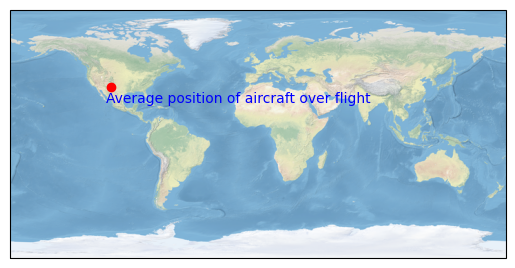

In [12]:
ax = plt.axes(projection=ccrs.PlateCarree())
ax.stock_img()

average_lon, average_lat = np.mean(lon_vals), np.mean(lat_vals)
plt.scatter(average_lon, average_lat, transform=ccrs.Geodetic(), c="r")
plt.text(
    average_lon - 3,
    average_lat - 12,
    "Average position of aircraft over flight",
    horizontalalignment="left",
    transform=ccrs.Geodetic(),
    c="blue",
)

plt.show()

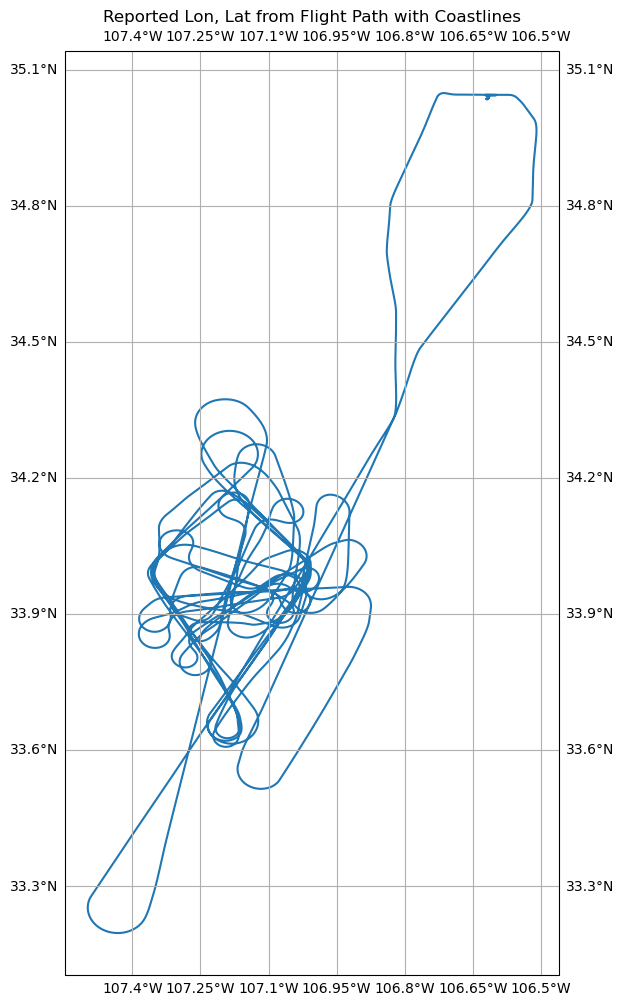

In [13]:
import cartopy.crs as ccrs

proj = ccrs.PlateCarree()  # cartopy projection
fig = plt.figure(figsize=(12, 12))  # size of plot
axes = plt.axes(projection=proj)  # plot transform
ax = plt.plot(lon_vals, lat_vals, transform=ccrs.PlateCarree())

gridlines = axes.gridlines(draw_labels=True)


plt.title("Reported Lon, Lat from Flight Path with Coastlines")
axes.coastlines()  # show maplines
plt.show()

### Exploration of Nasa Ames formatted aircraft data (MRF)

As before, we will download data from CEDA programmatically, however in this case, there are a lot more caveats as the data is held in a lesser standard. At some point in the data, the parameter name is given in the file extension, the majority of the files are Nasa Ames, but are given sometimes as .dat .out in addition to '.na'.   The Nasa Ames format

In [14]:
cert_dir = CERT_SECRET
visited_urls_ames = set()  # global sets to allow access in functions during recursion
download_links_ames = set()
start_data_dir_ames = (
    "./data/aircraft_data/nasa-ames_example"  # root directory for downloaded content
)
all_files = set()


def crawl_directory_ames(url, start_data_dir):
    if url in visited_urls_ames:
        return

    visited_urls_ames.add(url)

    response = requests.get(url, cert=(cert_dir))

    soup = BeautifulSoup(
        response.content, "html.parser"
    )  # parse the content, returns soup object

    if soup is None:  # if nothing is found in the htmlparse, end
        return

    for link in soup.find_all("a"):  # hrefs exist in anchor elements
        if link.has_attr("href"):
            href = link["href"]  # only explore links
        else:
            continue
        if href == "../":  # don't go up in directories
            continue
            # look in the directory
        elif href.endswith("/"):
            print("found dir:", href)
            crawl_directory_ames(
                os.path.join(url, href), os.path.join(start_data_dir, href)
            )
        elif href.endswith(".na"):  # save diserable files
            download_links_ames.add(
                os.path.join(url, href)
            )  # if chosen to mirror the directory setup as is online, good idea to just download the file instead of save download link
        else:
            if "." in href:
                all_files.add(
                    href
                )  # add uncaught file, out of interest in generating all the different file extensions


file_start_url_ames = "https://dap.ceda.ac.uk/badc/ukmo-mrf/data"
print("starting crawl")
crawl_directory_ames(file_start_url_ames, start_data_dir_ames)
print("crawl end")
# convert 1hz.nc set to sorted list (sorts by year, then alphabetically on ?flightcode?)
download_links_ames = sorted(
    list(download_links_ames), reverse=True
)  # reverse to make recent data appear first in the list

# print(download_links)
print(len(download_links_ames), "files found.")
map_get_file_extension = lambda x: x[x.rfind(".") :]
file_exts = map(map_get_file_extension, all_files)
print(
    "\nAll file extensions excluding .na (and files without extension):\n",
    sorted(list(set(file_exts))),
)  # set to remove duplicates, then sorted list

starting crawl
found dir: a254/
found dir: a257/
found dir: a258/
found dir: a259/
found dir: a260/
found dir: a297/
found dir: a298/
found dir: a308/
found dir: a309/
found dir: a311/
found dir: a312/
found dir: a313/
found dir: a318/
found dir: a319/
found dir: a320/
found dir: a330/
found dir: a331/
found dir: a360/
found dir: a400/
found dir: a431/
found dir: a444/
found dir: a445/
found dir: a475/
found dir: a476/
found dir: a477/
found dir: a478/
found dir: a479/
found dir: a480/
found dir: a481/
found dir: a512/
found dir: a531/
found dir: a532/
found dir: a533/
found dir: a534/
found dir: a536/
found dir: a574/
found dir: a575/
found dir: a576/
found dir: a577/
found dir: a578/
found dir: a579/
found dir: a580/
found dir: a581/
found dir: a584/
found dir: a646/
found dir: flightfolder/
found dir: a647/
found dir: flightfolder/
found dir: a658/
found dir: flightfolder/
found dir: a660/
found dir: flightfolder/
found dir: a661/
found dir: flightfolder/
found dir: a663/
found dir:

In [15]:
print(download_links_ames[0])
print(download_links_ames[-1])

https://dap.ceda.ac.uk/badc/ukmo-mrf/data/a782/he20000830_wnd.na
https://dap.ceda.ac.uk/badc/ukmo-mrf/data/a779/he20000825_clr.na


The result of the above cell allows for the assumption that the .na extension was chosen to be used for the nasa ames files in 4 of the flights from 779-782.

next, one of these flights shall be selected for exploration.

In [16]:
# get only one flights worth of na data
most_recent_file_dir = download_links_ames[0][0 : download_links_ames[0].rfind("/")]
most_recent_flight = most_recent_file_dir[most_recent_file_dir.rfind("/") + 1 :]
print("Taking flight:", most_recent_flight)
files_to_download = [
    most_recent_file
    for most_recent_file in download_links_ames
    if most_recent_flight in most_recent_file
]
print(len(files_to_download), "files to download.")

ames_save_directory = "./data/aircraft_data/nasa-ames_example/"

Taking flight: a782
30 files to download.


In [17]:
print("Starting download")
for ames_file in files_to_download:
    ames_file_name = ames_file.split("/")[-1]
    ames_file_name = most_recent_flight + "_" + ames_file_name
    ames_filepath = f"{ames_save_directory}{ames_file_name}"
    if not os.path.exists(
        ames_filepath
    ):  # don't download files if already exist on disk
        response = requests.get(ames_file, cert=(CERT_SECRET))
        response_content = response.content
        if response.status_code != 200:
            print(response_content)
            print(
                "\n!!!Exception, likely the certificate is not valid! response above!!!\n"
            )
            raise Exception()
        with open(ames_filepath, "wb") as f:
            f.write(response_content)
print("download end")

Starting download
download end


In [18]:
# get the downloaded na files to a list
ames_file_pattern_str = ames_save_directory + most_recent_flight + "*.na"
na_files_to_load = glob.glob(ames_file_pattern_str)

#### Notes on Nasa Ames Format

The Nasa Ames format is a plain text format, meaning, when the file is opened the data is visible in some text reader, similar to the more common .txt file extension. The Nasa Ames file format index (FFI) is specified in the within the files in our case as [1001](http://cedadocs.ceda.ac.uk/73/4/Ex1001.html). There are a few ways to open Nasa Ames files programmatically, some of which did not work in this case. [NASA Ames Processing in Python](https://github.com/cedadev/nappy) comes with a handy conversion tool, `na2nc`, which converts Nasa Ames files to netCDF files although the result from this data was that the variable units are not read correctly. [Pyaerocom](https://github.com/metno/pyaerocom) is another tool with the functionality of reading .na files, but would not import for tight iris version requirements. After failure to use both tools for easy conversion, manual inspection of the files, and reading the documentation on the file format and FFI allowed for reading the files using standard python file reading methods; For example, the 12th line until an integer lists all of the data measurement categories in the file, or the independent variable is always the same time value on index 8. The number of lines of non-data are given in the first line of the file, which can be read to access the tabular data.

In [19]:
# settings for fileread
time_variable_index_from_inspection = 8

In [20]:
%%time
# load
global_time_name = None
timevars = set()
ds_list = []
plane_list = []
for na_file in na_files_to_load:
    print("Start file:", na_file)
    data_list = []
    with open(na_file) as f:
        file_lines = f.readlines()
        variable_end_index = None
        for i in range(12, len(file_lines)):
            try:
                int(file_lines[i])
                variable_end_index = i
                break
            except:
                continue
        data_categories = file_lines[12:variable_end_index]
        header_line_count = int(file_lines[0].split(" ")[0])
        data_lines = file_lines[header_line_count:]
        for line in data_lines:
            separated_data = line.split()
            data_list.append(separated_data)
    df = pd.DataFrame(data_list)

    data_column_names = list(map(str.strip, data_categories))
    if global_time_name is None:
        global_time_name = file_lines[time_variable_index_from_inspection]
        global_time_name = "".join(
            global_time_name.split()
        )  # sometimes the whitespace of the read line is different, ensure consistency
        print("Updated time variable:", global_time_name)
        timevars.add(global_time_name)
    elif "".join(
            file_lines[time_variable_index_from_inspection].split()
        ) not in timevars:
        new_time_var = "".join(
            file_lines[time_variable_index_from_inspection].split()
        )
        print("New Time Variable Found:", new_time_var)
        timevars.add(new_time_var)
    time_variable = [global_time_name]
    data_column_names = time_variable + data_column_names
    df.columns = data_column_names
    df["File_Name"] = na_file
    if('_ds' in na_file):
        ds_list.append(df)
    else:
        plane_list.append(df)
print("Time names found:", timevars)

Start file: ./data/aircraft_data/nasa-ames_example/a782_he20000830_wnd.na
Updated time variable: ElapsedUTsfrom0hrson20000830
Start file: ./data/aircraft_data/nasa-ames_example/a782_he20000830_tw1.na
Start file: ./data/aircraft_data/nasa-ames_example/a782_he20000830_tmp.na
Start file: ./data/aircraft_data/nasa-ames_example/a782_he20000830_sil.na
Start file: ./data/aircraft_data/nasa-ames_example/a782_he20000830_red.na
Start file: ./data/aircraft_data/nasa-ames_example/a782_he20000830_rad.na
Start file: ./data/aircraft_data/nasa-ames_example/a782_he20000830_ps1.na
Start file: ./data/aircraft_data/nasa-ames_example/a782_he20000830_ge1.na
Start file: ./data/aircraft_data/nasa-ames_example/a782_he20000830_ds022.na
New Time Variable Found: ElapsedUTsfrom0hrson2000830
Start file: ./data/aircraft_data/nasa-ames_example/a782_he20000830_ds021.na
Start file: ./data/aircraft_data/nasa-ames_example/a782_he20000830_ds020.na
Start file: ./data/aircraft_data/nasa-ames_example/a782_he20000830_ds019.na

Sort the values per the common variable of time:

In [21]:
def concat_dataframe(df_list):
    concat_df = pd.concat(df_list)
    returning_df = concat_df.loc[:, concat_df.columns != 'File_Name'].astype(float)
    returning_df['File_Name'] = concat_df['File_Name']
    returning_df = returning_df.sort_values(global_time_name)
    returning_df.reset_index(drop=True, inplace=True)
    return returning_df

In [22]:
%%time
df_ds = concat_dataframe(ds_list)
df_plane = concat_dataframe(plane_list)
df_ds

CPU times: user 7.81 s, sys: 2.81 s, total: 10.6 s
Wall time: 10.6 s


,ElapsedUTsfrom0hrson20000830,data identifier,error flag (data identifier),air pressure(mb),error flag (air pressure),air temperature(degC),error flag (air temperature),relative humidity(%),error flag (relative humidity),wind direction(deg),...,error flag (gps longitude),GPS latitude(deg),error flag (GPS latitude),Geopotential altitude(m),error flag (Geopotential altitude),no. of satellites in GPS wind,error flag (no. of satellites in GPS wind),no. of satellites tracked by sonde,error flag (no. of satellites tracked by sonde),File_Name
0,38238.5,2.0,0.0,827.62,0.0,28.59,0.0,22.51,0.0,999.0,...,3.0,99.0,3.0,1372.76,0.0,99.0,3.0,99.0,3.0,./data/aircraft_data/nasa-ames_example/a782_he...
1,38239.0,2.0,0.0,827.62,0.0,28.59,0.0,22.35,0.0,999.0,...,3.0,99.0,3.0,1372.76,0.0,99.0,3.0,99.0,3.0,./data/aircraft_data/nasa-ames_example/a782_he...
2,38239.5,2.0,0.0,827.60,0.0,28.62,0.0,22.53,0.0,999.0,...,3.0,99.0,3.0,1373.04,0.0,99.0,3.0,99.0,3.0,./data/aircraft_data/nasa-ames_example/a782_he...
3,38240.0,2.0,0.0,827.38,0.0,28.56,0.0,22.69,0.0,999.0,...,3.0,99.0,3.0,1375.35,0.0,99.0,3.0,99.0,3.0,./data/aircraft_data/nasa-ames_example/a782_he...
4,38240.5,2.0,0.0,827.41,0.0,28.55,0.0,22.56,0.0,999.0,...,3.0,99.0,3.0,1375.01,0.0,99.0,3.0,99.0,3.0,./data/aircraft_data/nasa-ames_example/a782_he...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27569,54973.4,3.0,10.0,9999.00,3.0,99.00,3.0,999.00,3.0,999.0,...,3.0,99.0,3.0,99999.00,3.0,99.0,3.0,99.0,3.0,./data/aircraft_data/nasa-ames_example/a782_he...
27570,54973.9,3.0,10.0,9999.00,3.0,99.00,3.0,999.00,3.0,999.0,...,3.0,99.0,3.0,99999.00,3.0,99.0,3.0,99.0,3.0,./data/aircraft_data/nasa-ames_example/a782_he...
27571,54974.4,3.0,10.0,9999.00,3.0,99.00,3.0,999.00,3.0,999.0,...,3.0,99.0,3.0,99999.00,3.0,99.0,3.0,99.0,3.0,./data/aircraft_data/nasa-ames_example/a782_he...
27572,54974.9,3.0,10.0,9999.00,3.0,99.00,3.0,999.00,3.0,999.0,...,3.0,99.0,3.0,99999.00,3.0,99.0,3.0,99.0,3.0,./data/aircraft_data/nasa-ames_example/a782_he...


#### Cleaning data

More information about the specific data is required to proceed at this point. There exist NaNs (Not A Number) in the data for data from Nasa Ames files which did not report on the GPS coordinates of flight, though further investigation will show that the Nasa Ames format does not present NaN values on unknown data where some data for a variable is reported in a file, instead a flag is used and some hard-coded value is used such as 99.00 or 999.00. This behaviour is not desirable for data processing because integer values can interfere with mean or range calculations, plotting the data, etc. Inspecting the files shows that the data flags that are present next to each variable give context in a few categories for the reliability of the data that is flagged for:

```
ERROR FLAG 0 = good data
ERROR FLAG 1 = data expected good but requires corrections as described above
ERROR FLAG 2 = PTU or GPS errors, sensor not stabilised or data clearly wrong
ERROR FLAG 3 = missing or invalid data
```

As shown, error flags 2 and 3 contain data that is not usable, so the next step would be to remove all flagged data, set it to NaN, and remove remaining datapoints that are not helpful for our purposes

In [23]:
# set the bad data to NaN
def apply_error_flags(raw_df):
    error_flag_var_boolean = raw_df.columns.str.contains("error flag")
    df_error_flags = raw_df.loc[:, error_flag_var_boolean]
    good_data_mask = (df_error_flags == 2) | (df_error_flags == 3)
    flag_to_data = np.concatenate((error_flag_var_boolean[1:], [False]))
    df_data = raw_df.loc[:, flag_to_data]
    good_data_mask.columns = df_data.columns
    nan_df = df_data.mask(good_data_mask, other=np.NaN)
    nan_cols = nan_df.columns
    proc_df = raw_df.copy()
    proc_df.loc[:, nan_cols] = nan_df
    return proc_df

In [24]:
%%time
df_ds_proc = apply_error_flags(df_ds)
df_plane_proc = apply_error_flags(df_plane)
df_plane_proc

CPU times: user 249 ms, sys: 342 ms, total: 592 ms
Wall time: 591 ms


,ElapsedUTsfrom0hrson20000830,NORTHWARD WIND COMPT(M S-1 ),ERROR FLAG (NORTHWARD WIND COMPT),EASTWARD WIND COMPT (M S-1 ),ERROR FLAG (EASTWARD WIND COMPT ),VERTICAL WIND COMPT(M S-1 ),ERROR FLAG (VERTICAL WIND COMPT),TOTAL WATER CONTENT (G KG-1 ),ERROR FLAG (TOTAL WATER CONTENT ),STATIC PRESSURE (MB ),...,ERROR FLAG (CORRECTED LONGITUDE ),PRESSURE HEIGHT (METRES ),ERROR FLAG (PRESSURE HEIGHT ),DEW POINT (DEG K ),ERROR FLAG (DEW POINT ),CORR UPPER CLR FLUX (W M-2 ),ERROR FLAG (CORR UPPER CLR FLUX ),CORR LOWER CLR FLUX (W M-2 ),ERROR FLAG (CORR LOWER CLR FLUX ),File_Name
0,36300.000000,1.670410,0.0,5.324463,0.0,-1.373535,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,./data/aircraft_data/nasa-ames_example/a782_he...
1,36300.000000,NaN,NaN,NaN,NaN,NaN,NaN,13.917553,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,./data/aircraft_data/nasa-ames_example/a782_he...
2,36300.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,./data/aircraft_data/nasa-ames_example/a782_he...
3,36300.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,./data/aircraft_data/nasa-ames_example/a782_he...
4,36300.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,./data/aircraft_data/nasa-ames_example/a782_he...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2773933,56400.953125,NaN,NaN,NaN,NaN,NaN,NaN,999.000000,3.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,./data/aircraft_data/nasa-ames_example/a782_he...
2773934,56400.968750,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,981.84375,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,./data/aircraft_data/nasa-ames_example/a782_he...
2773935,56400.968750,-6.195557,0.0,-2.834717,0.0,0.263916,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,./data/aircraft_data/nasa-ames_example/a782_he...
2773936,56400.968750,NaN,NaN,NaN,NaN,NaN,NaN,999.000000,3.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,./data/aircraft_data/nasa-ames_example/a782_he...


In [25]:
# lower error flags either contain good data, or require corrections which will not be made in the tutorial, so drop the error flags
df_plane_proc.drop(list(df_plane_proc.filter(regex='ERROR FLAG')), inplace=True, axis = 1)
df_ds_proc.drop(list(df_ds_proc.filter(regex='error flag')), inplace=True, axis = 1)


In [26]:
print(df_plane_proc.columns)
print(df_ds_proc.columns)

Index(['ElapsedUTsfrom0hrson20000830', 'NORTHWARD WIND COMPT(M S-1   )',
       'EASTWARD WIND COMPT (M S-1   )', 'VERTICAL  WIND COMPT(M S-1   )',
       'TOTAL WATER CONTENT (G KG-1  )', 'STATIC PRESSURE     (MB      )',
       'DEICED TRUE TEMP    (DEG K   )', 'NON-DEICED TRUE TEMP(DEG K   )',
       'CORR UPPER I/R FLUX (W M-2   )', 'CORR LOWER I/R FLUX (W M-2   )',
       'CORR UPPER RED FLUX (W M-2   )', 'CORR LOWER RED FLUX (W M-2   )',
       'RADAR HEIGHT        (METRES  )', 'CORRECTED LATITUDE  (DEGREES )',
       'CORRECTED LONGITUDE (DEGREES )', 'PRESSURE HEIGHT     (METRES  )',
       'DEW POINT           (DEG K   )', 'CORR UPPER CLR FLUX (W M-2   )',
       'CORR LOWER CLR FLUX (W M-2   )', 'File_Name'],
      dtype='object')
Index(['ElapsedUTsfrom0hrson20000830', 'data identifier', 'air pressure(mb)',
       'air temperature(degC)', 'relative humidity(%)', 'wind direction(deg)',
       'wind speed(m/s)', 'wind error(m/s)', 'vertical velocity of sonde(m/s)',
       'gps l

Even some of the files reporting the flight coordinates do so in a way that is not consistent. It is important to remember that the purpose of a research flight will follow the purpose of the overall campaign, so while a type of data may have been recorded, care may not have been taken to record this data consistently through the flight. Some example of this would be that for some singular dropsonde files in this flight, the flight coordinates are reported at times, though there exists no point in time where all three lon/lat/alt coordinates are reported well at the same time, and the plot below could not be produced.

In [27]:
# if any of the coordinate values are NaN in a row, drop the row
def drop_vals_where_any_col_is_na(inp_df, col_names):
    boolean_dataframes = []
    # collect all desired boolean evaluations of the dataframe
    for col in col_names:
        boolean_dataframes.append(inp_df[col].notna())
    final_bool_series = boolean_dataframes[0] # initialize series to save final evaluation to
    for pd_series in boolean_dataframes:
        final_bool_series = final_bool_series & pd_series
    return inp_df[final_bool_series].copy()
    
ds_coord_names = ["GPS latitude(deg)","gps longitude(deg)", "Geopotential altitude(m)"]
plane_coord_names = ['CORRECTED LATITUDE  (DEGREES )','CORRECTED LONGITUDE (DEGREES )','PRESSURE HEIGHT     (METRES  )']

df_plane_constrained = drop_vals_where_any_col_is_na(df_plane_proc, plane_coord_names)
df_ds_constrained = drop_vals_where_any_col_is_na(df_ds_proc, ds_coord_names)
df_ds_constrained

,ElapsedUTsfrom0hrson20000830,data identifier,air pressure(mb),air temperature(degC),relative humidity(%),wind direction(deg),wind speed(m/s),wind error(m/s),vertical velocity of sonde(m/s),gps longitude(deg),GPS latitude(deg),Geopotential altitude(m),no. of satellites in GPS wind,no. of satellites tracked by sonde,File_Name
109,38293.0,3.0,499.49,-8.46,51.79,82.75,14.33,0.62,-14.86,-0.00972,13.31455,5554.96,4.0,4.0,./data/aircraft_data/nasa-ames_example/a782_he...
110,38293.5,3.0,500.00,-8.47,51.61,82.89,14.38,0.62,-15.15,-0.01049,13.31521,5547.12,4.0,4.0,./data/aircraft_data/nasa-ames_example/a782_he...
111,38294.0,3.0,500.46,-8.44,51.42,83.22,14.14,0.62,-15.38,-0.01055,13.31521,5539.88,4.0,4.0,./data/aircraft_data/nasa-ames_example/a782_he...
112,38294.5,3.0,501.01,-8.41,54.61,83.36,14.00,0.62,-15.16,-0.01068,13.31529,5531.49,4.0,4.0,./data/aircraft_data/nasa-ames_example/a782_he...
113,38295.0,3.0,501.51,-8.41,62.73,83.76,14.08,0.62,-16.02,-0.01074,13.31529,5523.73,4.0,4.0,./data/aircraft_data/nasa-ames_example/a782_he...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27522,54949.9,3.0,992.23,23.87,80.74,48.28,4.33,0.03,-11.46,-20.85970,15.98352,-272.58,7.0,7.0,./data/aircraft_data/nasa-ames_example/a782_he...
27523,54950.4,3.0,992.84,23.94,80.39,48.73,4.35,0.05,-11.58,-20.85972,15.98351,-277.95,7.0,7.0,./data/aircraft_data/nasa-ames_example/a782_he...
27524,54950.9,3.0,993.51,23.98,80.22,49.66,4.36,0.03,-11.66,-20.85973,15.98349,-283.86,7.0,7.0,./data/aircraft_data/nasa-ames_example/a782_he...
27525,54951.4,3.0,994.14,24.05,79.88,50.11,4.29,0.03,-11.51,-20.85975,15.98347,-289.47,7.0,7.0,./data/aircraft_data/nasa-ames_example/a782_he...


In [28]:
df_plane_constrained

,ElapsedUTsfrom0hrson20000830,NORTHWARD WIND COMPT(M S-1 ),EASTWARD WIND COMPT (M S-1 ),VERTICAL WIND COMPT(M S-1 ),TOTAL WATER CONTENT (G KG-1 ),STATIC PRESSURE (MB ),DEICED TRUE TEMP (DEG K ),NON-DEICED TRUE TEMP(DEG K ),CORR UPPER I/R FLUX (W M-2 ),CORR LOWER I/R FLUX (W M-2 ),CORR UPPER RED FLUX (W M-2 ),CORR LOWER RED FLUX (W M-2 ),RADAR HEIGHT (METRES ),CORRECTED LATITUDE (DEGREES ),CORRECTED LONGITUDE (DEGREES ),PRESSURE HEIGHT (METRES ),DEW POINT (DEG K ),CORR UPPER CLR FLUX (W M-2 ),CORR LOWER CLR FLUX (W M-2 ),File_Name
5,36300.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.483826,2.216839,261.860321,NaN,NaN,NaN,./data/aircraft_data/nasa-ames_example/a782_he...
143,36301.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.483784,2.216001,260.195770,NaN,NaN,NaN,./data/aircraft_data/nasa-ames_example/a782_he...
283,36302.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.483742,2.215163,259.155457,NaN,NaN,NaN,./data/aircraft_data/nasa-ames_example/a782_he...
415,36303.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.483707,2.214327,257.907227,NaN,NaN,NaN,./data/aircraft_data/nasa-ames_example/a782_he...
557,36304.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.483669,2.213491,256.313721,NaN,NaN,NaN,./data/aircraft_data/nasa-ames_example/a782_he...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2773249,56396.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.504067,-22.935074,439.343994,NaN,NaN,NaN,./data/aircraft_data/nasa-ames_example/a782_he...
2773388,56397.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.504707,-22.935448,437.087189,NaN,NaN,NaN,./data/aircraft_data/nasa-ames_example/a782_he...
2773526,56398.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.505348,-22.935860,434.549255,NaN,NaN,NaN,./data/aircraft_data/nasa-ames_example/a782_he...
2773668,56399.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.505974,-22.936272,431.448639,NaN,NaN,NaN,./data/aircraft_data/nasa-ames_example/a782_he...


In [29]:
# replace the columns for easy of following plot readings
df_ds_constrained.rename(columns =dict(zip(ds_coord_names, ['ds_lat','ds_lon','ds_height'])), inplace=True)
df_plane_constrained.rename(columns = dict(zip(plane_coord_names, ['pl_lat','pl_lon','pl_height'])), inplace=True)

Another point on the data: since a plot of the data is about to be made, it is important to point out that despite the existence of data error flags, the data _STILL_ may not be in a state that is reasonable. summary metrics of the data, and summary plots should be taken to ensure that there are no unfeasible spikes in the data, and consideration as to why this data may be questionable, more information can be found in the comments of the file itself, though it is not possible for the file to cover all bases when talking about the potential inconsistency of the sensors.

The reason DS and plane files have been kept seperate, again comes from a look at the metadata of the files. DS in the files stands for Dropsonde, which is an instrument dropped from the plane to record measurements, whereas files without the ds marker are sensors that are on the plane itself. The plots of coordinates should make this more obvious.

First look at the altitude reported over time

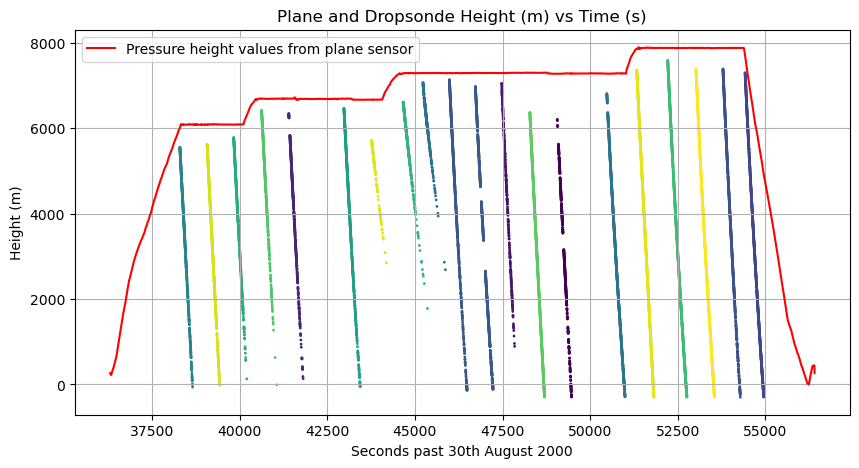

In [30]:
fig = plt.figure(figsize=(10,5))
plt.scatter(df_ds_constrained['ElapsedUTsfrom0hrson20000830'],df_ds_constrained['ds_height'],s=1, c=list(map(hash, df_ds_constrained['File_Name'])))
plt.plot(df_plane_constrained["ElapsedUTsfrom0hrson20000830"], df_plane_constrained['pl_height'], label='Pressure height values from plane sensor', c='red')
plt.grid()
plt.legend()
plt.ylabel("Height (m)")
plt.xlabel("Seconds past 30th August 2000")
plt.title("Plane and Dropsonde Height (m) vs Time (s)")


plt.show()

Plot the flight path as in part 1:

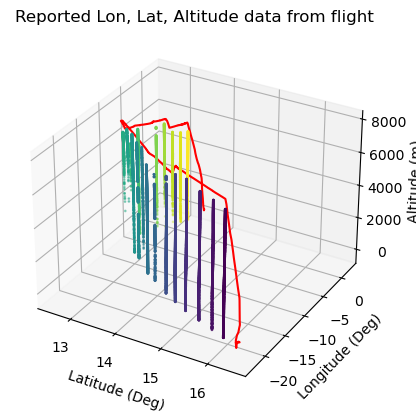

In [31]:
fig = plt.figure()
ax = fig.add_subplot(projection="3d")
ax.scatter(
    df_ds_constrained['ds_lat'], df_ds_constrained['ds_lon'], df_ds_constrained['ds_height'], c=list(df_ds_constrained['ds_lon']), s=1
)  # cary the color with the longitude
ax.plot(df_plane_constrained['pl_lat'], df_plane_constrained['pl_lon'], df_plane_constrained['pl_height'], c='red')
ax.set_xlabel("Latitude (Deg)")
ax.set_ylabel("Longitude (Deg)")
ax.set_zlabel("Altitude (m)")
plt.title("Reported Lon, Lat, Altitude data from flight")
plt.show()

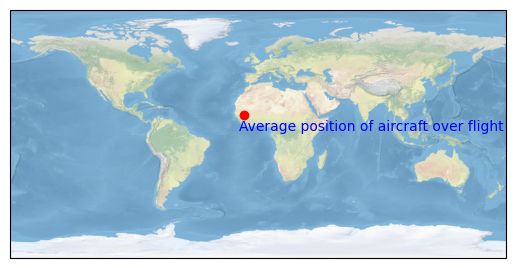

In [32]:
ax = plt.axes(projection=ccrs.PlateCarree())
ax.stock_img()

average_lat, average_lon = np.mean(df_plane_constrained['pl_lat']), np.mean(df_plane_constrained['pl_lon'])
plt.scatter(average_lon, average_lat, transform=ccrs.Geodetic(), c="r")
plt.text(
    average_lon - 3,
    average_lat - 12,
    "Average position of aircraft over flight",
    horizontalalignment="left",
    transform=ccrs.Geodetic(),
    c="blue",
)

plt.show()

also give a topdown view of the flight

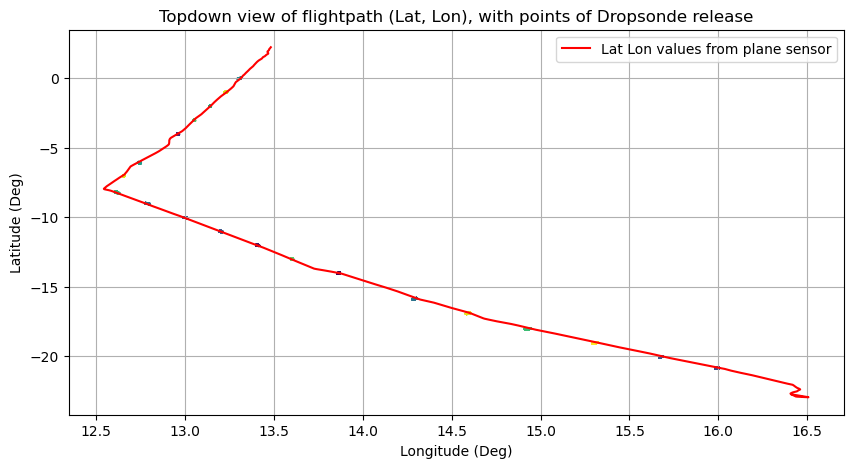

In [33]:
fig = plt.figure(figsize=(10,5))
plt.scatter(df_ds_constrained['ds_lat'],df_ds_constrained['ds_lon'],s=1, c=list(map(hash, df_ds_constrained['File_Name'])))
plt.plot(df_plane_constrained["pl_lat"], df_plane_constrained['pl_lon'], label='Lat Lon values from plane sensor', c='red')
plt.grid()
plt.legend()

plt.xlabel("Longitude (Deg)")
plt.ylabel("Latitude (Deg)")
plt.title("Topdown view of flightpath (Lat, Lon), with points of Dropsonde release")

plt.show()

### Integrating Climate and Aircraft Data

In [34]:
# get climate data
def esgf_search(server="https://esgf-node.llnl.gov/esg-search/search",
                files_type="OPENDAP", local_node=True, project="CMIP6",
                verbose=False, format="application%2Fsolr%2Bjson",
                use_csrf=False, **search):
    client = requests.session()
    payload = search
    payload["project"] = project
    payload["type"]= "File"
    if local_node:
        payload["distrib"] = "false"
    if use_csrf:
        client.get(server)
        if 'csrftoken' in client.cookies:
            # Django 1.6 and up
            csrftoken = client.cookies['csrftoken']
        else:
            # older versions
            csrftoken = client.cookies['csrf']
        payload["csrfmiddlewaretoken"] = csrftoken

    payload["format"] = format

    offset = 0
    numFound = 10000
    all_files = []
    files_type = files_type.upper()
    while offset < numFound:
        payload["offset"] = offset
        url_keys = [] 
        for k in payload:
            url_keys += ["{}={}".format(k, payload[k])]

        url = "{}/?{}".format(server, "&".join(url_keys))
        print(url)
        r = client.get(url)
        r.raise_for_status()
        resp = r.json()["response"]
        numFound = int(resp["numFound"])
        resp = resp["docs"]
        offset += len(resp)
        for d in resp:
            if verbose:
                for k in d:
                    print("{}: {}".format(k,d[k]))
            url = d["url"]
            for f in d["url"]:
                sp = f.split("|")
                if sp[-1] == files_type:
                    all_files.append(sp[0].split(".html")[0])
    return sorted(all_files)

In [35]:
result = esgf_search(activity_id='CMIP', table_id='Amon', variable_id='ta', experiment_id = 'historical', variant_label = 'r1i1p1f2', nominal_resolution = '50 km')
ds = xr.open_mfdataset(result, combine='by_coords')
ds

https://esgf-node.llnl.gov/esg-search/search/?activity_id=CMIP&table_id=Amon&variable_id=ta&experiment_id=historical&variant_label=r1i1p1f2&nominal_resolution=50 km&project=CMIP6&type=File&distrib=false&format=application%2Fsolr%2Bjson&offset=0


<xarray.Dataset>
Dimensions:      (lat: 360, lon: 720, plev: 19, time: 1980, axis_nbounds: 2)
Coordinates:
  * lat          (lat) float64 -89.62 -89.12 -88.62 -88.13 ... 88.62 89.12 89.62
  * lon          (lon) float64 0.0 0.5 1.0 1.5 2.0 ... 358.0 358.5 359.0 359.5
  * plev         (plev) float32 1e+05 9.25e+04 8.5e+04 ... 1e+03 500.0 100.0
  * time         (time) datetime64[ns] 1850-01-16T12:00:00 ... 2014-12-16T12:...
Dimensions without coordinates: axis_nbounds
Data variables:
    time_bounds  (time, axis_nbounds) datetime64[ns] dask.array<chunksize=(600, 2), meta=np.ndarray>
    ta           (time, plev, lat, lon) float32 dask.array<chunksize=(600, 19, 360, 720), meta=np.ndarray>
Attributes: (12/53)
    Conventions:                     CF-1.7 CMIP-6.2
    creation_date:                   2019-05-23T13:08:44Z
    description:                     CMIP6 historical
    title:                           CNRM-CM6-1-HR model output prepared for ...
    activity_id:                     CMIP
    contact:                         contact.cmip@meteo.fr
    ...                              ...
    xios_commit:                     1442-shuffle
    nemo_gelato_commit:              84a9e3f161dade7_8250e198106a168
    arpege_minor_version:            6.3.3
    history:                         none
    tracking_id:                     hdl:21.14100/c3aee425-8107-4bd9-8334-7fd...
    DODS_EXTRA.Unlimited_Dimension:  time

In [36]:
# import dask
# data_ok = ds.ta.load()
# print(data_ok)
# with dask.config.set(**{'array.slicing.split_large_chunks': True}):
#     data_ok.interp(time='2014-12-15', plev=7000.).squeeze().plot()

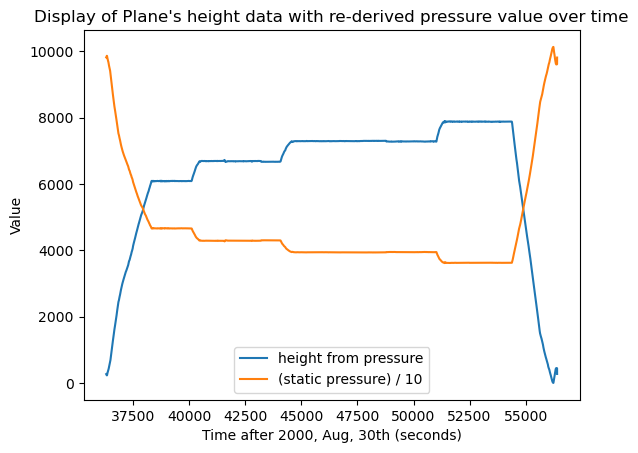

In [93]:
# metadata of _ps1 file: Pressure height is 44330.77*(1.-(static pressure/1013.25)**0.19026)
# so, static pressure = (-0.00008417 * height(m) + 3.73136421)**5.25596552
conversion_factor = 100 # conversion factor for data to align with climate data
df_plane_constrained['Pressure height (static pressure)'] = ((-0.00008417 * df_plane_constrained['pl_height'] + 3.73136421)**5.25596552) * conversion_factor
df_plane_constrained[['Pressure height (static pressure)', 'pl_height']].head(20)
plt.plot(df_plane_constrained["ElapsedUTsfrom0hrson20000830"], df_plane_constrained['pl_height'], label='height from pressure' )
plt.plot(df_plane_constrained["ElapsedUTsfrom0hrson20000830"], df_plane_constrained['Pressure height (static pressure)'] / 10, label='(static pressure) / 10')
plt.ylabel('Value')
plt.xlabel("Time after 2000, Aug, 30th (seconds)")
plt.legend()
plt.title("Display of Plane's height data with re-derived pressure value over time")
plt.show()

In [38]:
#subset the climate data to the same area of the flight data
import datetime
start_time = datetime.timedelta(seconds = int(df_plane_constrained["ElapsedUTsfrom0hrson20000830"].min()))
air_data_unit = datetime.datetime(2000, 8, 30, hour=0, minute=0, second=0)
end_time = datetime.timedelta(seconds = int(df_plane_constrained["ElapsedUTsfrom0hrson20000830"].max()))
end_time = end_time +  air_data_unit
start_time = start_time + air_data_unit
min_pressure_of_plane = np.min(df_plane_constrained['Pressure height (static pressure)'])
print("Min pressure:", min_pressure_of_plane)
print("Plane start and end:",start_time, end_time)
print("Average lat, lon of flight:", average_lat, average_lon)

Min pressure: 36121.780431787076
Plane start and end: 2000-08-30 10:05:00 2000-08-30 15:40:00
Average lat, lon of flight: 13.889712785383812 -10.47234396938031


In [39]:
constrained_ds = ds.sel(lat=slice(0, 20), lon=slice(340,360), plev=slice(20001,), time='2000')
constrained_ds

<xarray.Dataset>
Dimensions:      (lat: 40, lon: 40, plev: 9, time: 12, axis_nbounds: 2)
Coordinates:
  * lat          (lat) float64 0.2497 0.749 1.248 1.748 ... 18.72 19.22 19.72
  * lon          (lon) float64 340.0 340.5 341.0 341.5 ... 358.5 359.0 359.5
  * plev         (plev) float32 1e+05 9.25e+04 8.5e+04 ... 4e+04 3e+04 2.5e+04
  * time         (time) datetime64[ns] 2000-01-16T12:00:00 ... 2000-12-16T12:...
Dimensions without coordinates: axis_nbounds
Data variables:
    time_bounds  (time, axis_nbounds) datetime64[ns] dask.array<chunksize=(12, 2), meta=np.ndarray>
    ta           (time, plev, lat, lon) float32 dask.array<chunksize=(12, 9, 40, 40), meta=np.ndarray>
Attributes: (12/53)
    Conventions:                     CF-1.7 CMIP-6.2
    creation_date:                   2019-05-23T13:08:44Z
    description:                     CMIP6 historical
    title:                           CNRM-CM6-1-HR model output prepared for ...
    activity_id:                     CMIP
    contact:                         contact.cmip@meteo.fr
    ...                              ...
    xios_commit:                     1442-shuffle
    nemo_gelato_commit:              84a9e3f161dade7_8250e198106a168
    arpege_minor_version:            6.3.3
    history:                         none
    tracking_id:                     hdl:21.14100/c3aee425-8107-4bd9-8334-7fd...
    DODS_EXTRA.Unlimited_Dimension:  time

In [40]:
constrained_ds_ta_vals = constrained_ds.ta.compute()

In [41]:
def seconds_to_HHMMSSm(seconds_float):
    hour = int(seconds_float / 3600)
    minutes = int(seconds_float / 60) % 60
    seconds = int(seconds_float % 60)
    micro_second_factor = 1000000
    extra = int(round(seconds_float % 1, 1) * micro_second_factor)
    return hour, minutes, seconds, extra
    
def seconds_to_datetime(seconds_float, YYMMDD):
    hour, minutes, seconds, micros = seconds_to_HHMMSSm(seconds_float)
    year = air_data_unit.year
    month = air_data_unit.month
    day = air_data_unit.day
    return datetime.datetime(year, month, day, hour, minutes, seconds, micros)


In [42]:
datetime_map = lambda x: seconds_to_datetime(x, air_data_unit)
df_plane_constrained['Time as Datetime'] = df_plane_constrained["ElapsedUTsfrom0hrson20000830"].map(datetime_map)
# df_plane_constrained['Time as datetime'] = df_plane_constrained['Time as string'].apply(
#     lambda x: (datetime.datetime.strptime(x, str_format) + start_time)
# )
flight_point_array = list(zip(df_plane_constrained['pl_lat'], df_plane_constrained['pl_lon'], df_plane_constrained['Pressure height (static pressure)'], df_plane_constrained['Time as Datetime']))

In [53]:
constrained_ds_ta_vals = constrained_ds_ta_vals.interpolate_na('lat')
constrained_ds_ta_vals = constrained_ds_ta_vals.interpolate_na('lon')
constrained_ds_ta_vals = constrained_ds_ta_vals.interpolate_na('time')
constrained_ds_ta_vals = constrained_ds_ta_vals.dropna('plev')
constrained_ds_ta_vals_data = constrained_ds_ta_vals.data
print(np.isnan(np.min(constrained_ds_ta_vals_data)))

False


In [57]:
constrained_ds_ta_vals

<xarray.DataArray 'ta' (time: 12, plev: 8, lat: 40, lon: 40)>
array([[[[292.61914, 292.6162 , 292.6303 , ..., 293.38327, 293.36905,
          293.37866],
         [292.57974, 292.58063, 292.59503, ..., 293.4033 , 293.39206,
          293.40842],
         [292.6048 , 292.5912 , 292.6139 , ..., 293.4229 , 293.4528 ,
          293.48395],
         ...,
         [288.4777 , 289.0109 , 289.4301 , ..., 293.0025 , 293.05737,
          293.044  ],
         [288.0007 , 288.52295, 288.96033, ..., 292.507  , 292.60272,
          292.65103],
         [287.52814, 288.05338, 288.51883, ..., 291.9915 , 292.12512,
          292.22443]],

        [[288.73428, 288.76245, 288.79257, ..., 289.7619 , 289.76285,
          289.81024],
         [288.72452, 288.7412 , 288.7572 , ..., 289.75418, 289.78424,
          289.84583],
         [288.72632, 288.72824, 288.74524, ..., 289.7484 , 289.79822,
          289.87402],
...
         [231.4216 , 231.42963, 231.44283, ..., 231.85335, 231.87454,
          231.8927 ],
         [231.055  , 231.0598 , 231.07376, ..., 231.65009, 231.66571,
          231.67754],
         [230.73242, 230.72968, 230.73805, ..., 231.45398, 231.46584,
          231.47757]],

        [[225.16405, 225.16174, 225.16528, ..., 225.3942 , 225.3957 ,
          225.41756],
         [225.1761 , 225.17189, 225.1826 , ..., 225.38708, 225.38605,
          225.40886],
         [225.2034 , 225.20001, 225.21327, ..., 225.38403, 225.39085,
          225.40683],
         ...,
         [221.94788, 221.93634, 221.9335 , ..., 221.90047, 221.92801,
          221.95459],
         [221.69995, 221.69185, 221.68533, ..., 221.68524, 221.70879,
          221.7351 ],
         [221.45093, 221.44771, 221.44205, ..., 221.47728, 221.49017,
          221.51088]]]], dtype=float32)
Coordinates:
  * lat      (lat) float64 0.2497 0.749 1.248 1.748 ... 18.22 18.72 19.22 19.72
  * lon      (lon) float64 340.0 340.5 341.0 341.5 ... 358.0 358.5 359.0 359.5
  * plev     (plev) float32 9.25e+04 8.5e+04 7e+04 6e+04 ... 4e+04 3e+04 2.5e+04
  * time     (time) datetime64[ns] 2000-01-16T12:00:00 ... 2000-12-16T12:00:00
Attributes:
    long_name:           Air Temperature
    units:               K
    online_operation:    average
    cell_methods:        time: mean
    interval_operation:  900 s
    interval_write:      1 month
    standard_name:       air_temperature
    description:         Air Temperature
    history:             none
    cell_measures:       area: areacella
    _ChunkSizes:         [  1  19 360 720]

In [78]:
interpolated_temperature_list = []
for lat, lon, height, time in flight_point_array:
    interpolated_temperature_list.append(float(constrained_ds_ta_vals.interp(lat=lat, lon=lon, plev=np.float32(height), time=time, kwargs={'fill_value' : 'extrapolate'}).data))
df_plane_constrained['temp interp (K)'] = interpolated_temperature_list
df_plane_constrained['temp interp (K)']

5          186.893710
143        186.735718
283        186.637476
415        186.519043
557        186.367627
              ...    
2773249     43.050555
2773388     42.452706
2773526     41.787436
2773668     40.988281
2773802     11.093620
Name: temp interp (K), Length: 20101, dtype: float64

In [84]:
plane_non_deice_df = df_plane_proc[["ElapsedUTsfrom0hrson20000830", 'NON-DEICED TRUE TEMP(DEG K   )']].dropna()
plane_deice_df = df_plane_proc[["ElapsedUTsfrom0hrson20000830", 'DEICED TRUE TEMP    (DEG K   )']].dropna()

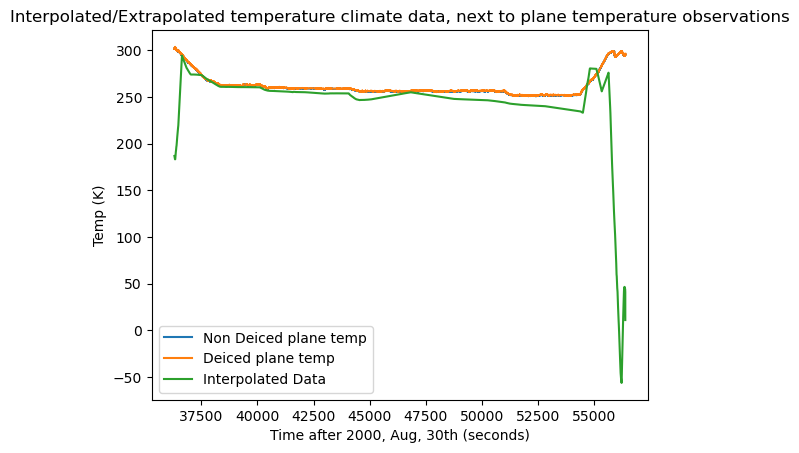

In [90]:
plt.plot(plane_non_deice_df["ElapsedUTsfrom0hrson20000830"], plane_non_deice_df['NON-DEICED TRUE TEMP(DEG K   )'], label='Non Deiced plane temp' )
plt.plot(plane_deice_df["ElapsedUTsfrom0hrson20000830"], plane_deice_df['DEICED TRUE TEMP    (DEG K   )'], label='Deiced plane temp')
plt.plot(df_plane_constrained["ElapsedUTsfrom0hrson20000830"], df_plane_constrained['temp interp (K)'], label='Interpolated Data')
plt.title("Interpolated/Extrapolated temperature climate data, with plane temperature observations")
plt.ylabel("Temp (K)")
plt.xlabel("Time after 2000, Aug, 30th (seconds)")
plt.legend()
plt.show()

## Data Statement

__Data used in this tutorial uses FAAM data__

__Contains public sector information licensed under the Open Government Licence v3.0.__

- Link to Open Government Licence: https://www.nationalarchives.gov.uk/doc/open-government-licence/version/3/
- Sources of Data: https://data.ceda.ac.uk/badc/faam and https://data.ceda.ac.uk/badc/ukmo-mrf/

______________________________________________________________________

## References

- [CEDA](https://www.ceda.ac.uk)
- [FAAM](https://www.faam.ac.uk)
- [Meteorological Research Flight (MRF) facility](https://catalogue.ceda.ac.uk/uuid/605b99a139b1162de6a1096a11b0a8b4#:~:text=The%20Met.%20Research%20Flight%20%28MRF%29%20was%20a%20Met,to%202001%20and%20flew%20over%201800%20research%20sorties.)
- [Nasa Ames](https://espo.nasa.gov/content/Ames_Format_Overview)
- [netCDF](https://en.wikipedia.org/wiki/NetCDF)
- [CEDA Certificate Guide](https://help.ceda.ac.uk/article/4442-ceda-opendap-scripted-interactions)
- [Xarray](https://xarray.dev)
- [Matplotlib](https://matplotlib.org/)
- [Pandas](https://pandas.pydata.org)
- [Recursion](https://en.wikipedia.org/wiki/Recursion_%28computer_science%29)
- [Depth-First-Search](https://en.wikipedia.org/wiki/Depth-first_search)
- [Beautiful Soup](https://beautiful-soup-4.readthedocs.io/en/latest/)
- [CartoPy](https://scitools.org.uk/cartopy)
- [.na FFI 1001](http://cedadocs.ceda.ac.uk/73/4/Ex1001.html)
- [NASA Ames Processing in Python](https://github.com/cedadev/nappy)
- [Pyaerocom](https://github.com/metno/pyaerocom)